In [70]:
##### Bit Error Rate of BPSK
import numpy as np
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB
block_size=8;
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath( "C:\Program Files\MATLAB\R2023b" );
BER_theoritical=eng.berawgn(Eb_No,'psk',2.0,'nondiff')
eng.semilogy(Eb_No,BER_theoritical,'DisplayName','theoritical BER')


In [81]:
##### Block Error Rate of BPSK
Block_error_rate=np.subtract(1,np.power(np.subtract(1,BER_theoritical),block_size))
eng.figure()
eng.semilogy(Eb_No,BER_theoritical,'DisplayName','theoritical BER')

In [72]:
import numpy as np
import random
n=7
k=4
M=2**k
#Generate random numbers between 0 and 15 for training data
symbols = np.random.randint(0,M,100000)
X_train = np.zeros((symbols.size, symbols.max()+1))
X_train[np.arange(symbols.size),symbols] = 1
#X_train.shape

In [73]:
#Generate random numbers between 0 and 15 for test data
symbols = np.random.randint(0,M,10000)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

In [74]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model 
from keras.layers import Input, Dense, ReLU, BatchNormalization 
inputs= X_test.shape[1]

In [4]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(CustomLayer, self).get_config()
        config.update({"units": self.units})
        return config


def custom_activation(x,axis=-1):
    return tf.abs(x)/tf.sqrt(tf.reduce_sum(x*x, axis=axis, keepdims=True)/x.shape[1])

In [76]:
#define the encoder 
encoder_input= Input(shape=(inputs,))
encoder_layer=Dense(inputs, activation="relu")(encoder_input)
encoder_layer=Dense(n, activation="linear")(encoder_layer)
encoder_output= BatchNormalization()(encoder_layer) 

In [77]:
# define the channel 
R=4/7;
Eb_No_training=7; ## dB
Eb_No_training_ratio=10**(Eb_No_training/10);
stddev=(2*R*Eb_No_training_ratio)**(-0.5);
channel_output=tf.keras.layers.GaussianNoise(stddev)(encoder_output)

In [78]:
# define the decoder 
decoder= Dense(inputs, activation="relu")(channel_output) 
decoder_output = Dense(inputs, activation="softmax")(decoder)

In [79]:
# define the autoencoder

autoencoder=Model(inputs=encoder_input, outputs=decoder_output)

## encoder side
encoder=Model(inputs=encoder_input, outputs=encoder_output)

#decoder side 
decoder=Model(inputs=channel_output, outputs=decoder_output)

In [80]:
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history=autoencoder.fit(X_train,X_train,epochs=30, validation_data=(X_test,X_test),batch_size=128)
#autoencoder.save("functional_encoder.h5")

Epoch 1/30
782/782 [==============================] - 3s 2ms/step - loss: 0.5343 - accuracy: 0.8910 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 2/30
782/782 [==============================] - 1s 2ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/30
782/782 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.5531e-04 - val_accuracy: 1.0000
Epoch 4/30
782/782 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4505e-04 - val_accuracy: 1.0000
Epoch 5/30
782/782 [==============================] - 1s 2ms/step - loss: 5.8150e-04 - accuracy: 1.0000 - val_loss: 6.7472e-05 - val_accuracy: 1.0000
Epoch 6/30
782/782 [==============================] - 1s 2ms/step - loss: 3.3012e-04 - accuracy: 1.0000 - val_loss: 3.4416e-05 - val_accuracy: 1.0000
Epoch 7/30
782/782 [==============================] - 1s 2ms/step - loss: 2.0017e-04 - accuracy: 1.0000 - val_loss: 1.8111e-

4/4 [==============================] - 0s 1ms/step


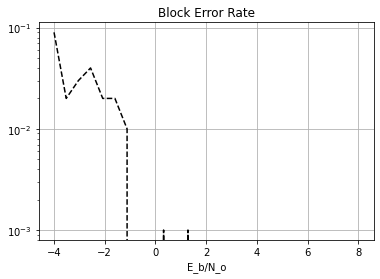

In [87]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=100;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB

BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
    if Eb_No[i]<=0:
        Eb_No_ratio=10**(Eb_No[i]/10);
        stddev=(2*R*Eb_No_ratio)**(-0.5);
        encodedsymbols=encoder.predict(X_test)
        noise = np.random.normal(0,stddev,[test_size,n])
        noisy=encodedsymbols+noise
        a=decoder.predict(noisy)
        idx = np.argmax(a, axis=-1)
        a = np.zeros( a.shape )
        a[ np.arange(a.shape[0]), idx] = 1
        recovered_symbols=np.argmax(a, axis=1)
        errors=np.count_nonzero(recovered_symbols-symbols)
        BER[i]=errors/len(symbols)
    else:
        BE=np.zeros(1)
        for jj in range(10):
            Eb_No_ratio=10**(Eb_No[i]/10);
            stddev=(2*R*Eb_No_ratio)**(-0.5);
            encodedsymbols=encoder.predict(X_test)
            noise = np.random.normal(0,stddev,[test_size,n])
            noisy=encodedsymbols+noise
            a=decoder.predict(noisy)
            idx = np.argmax(a, axis=-1)
            a = np.zeros( a.shape )
            a[ np.arange(a.shape[0]), idx] = 1
            recovered_symbols=np.argmax(a, axis=1)
            errors=np.count_nonzero(recovered_symbols-symbols)
            Erorrrrs=errors/len(symbols)
            BE+=Erorrrrs
        BER[i]=BE/10

import matplotlib.pyplot as plt
plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()

In [2]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=1000000;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB

BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
    if Eb_No[i]<=0:
        Eb_No_ratio=10**(Eb_No[i]/10);
        stddev=(2*R*Eb_No_ratio)**(-0.5);
        encodedsymbols=encoder.predict(X_test)
        noise = np.random.normal(0,stddev,[test_size,n])
        noisy=encodedsymbols+noise
        a=decoder.predict(noisy)
        idx = np.argmax(a, axis=-1)
        a = np.zeros( a.shape )
        a[ np.arange(a.shape[0]), idx] = 1
        recovered_symbols=np.argmax(a, axis=1)
        errors=np.count_nonzero(recovered_symbols-symbols)
        BER[i]=errors/len(symbols)
    else:
        BE=np.zeros(1)
        for jj in range(10):
            Eb_No_ratio=10**(Eb_No[i]/10);
            stddev=(2*R*Eb_No_ratio)**(-0.5);
            encodedsymbols=encoder.predict(X_test)
            noise = np.random.normal(0,stddev,[test_size,n])
            noisy=encodedsymbols+noise
            a=decoder.predict(noisy)
            idx = np.argmax(a, axis=-1)
            a = np.zeros( a.shape )
            a[ np.arange(a.shape[0]), idx] = 1
            recovered_symbols=np.argmax(a, axis=1)
            errors=np.count_nonzero(recovered_symbols-symbols)
            Erorrrrs=errors/len(symbols)
            BE+=Erorrrrs
        BER[i]=BE/10


NameError: name 'np' is not defined

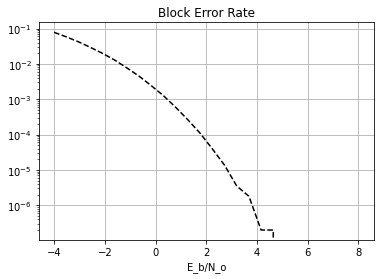

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()

In [ ]:
np.savez('BER_7_4.npz', BER=BER,Eb_No=Eb_No)
d = np.load('BER_7_4.npz')
print(d['BER'])
print(d['Eb_No'])

[7.7904e-02 5.7969e-02 4.2060e-02 2.9036e-02 1.9622e-02 1.2637e-02
 7.5900e-03 4.4300e-03 2.3850e-03 1.2432e-03 5.8250e-04 2.5870e-04
 1.0830e-04 3.9200e-05 1.3600e-05 3.5000e-06 1.8000e-06 2.0000e-07
 2.0000e-07 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
[-4.   -3.52 -3.04 -2.56 -2.08 -1.6  -1.12 -0.64 -0.16  0.32  0.8   1.28
  1.76  2.24  2.72  3.2   3.68  4.16  4.64  5.12  5.6   6.08  6.56  7.04
  7.52  8.  ]


In [ ]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 7)                 119       
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 7)                0         
 se)                                                             
                                                                 
 dense_4 (Dense)             (None, 16)                128   

In [ ]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 7)                 119       
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
Total params: 419
Trainable params: 405
Non-trainable params: 14
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                128       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encodedsymbols=encoder.predict(X_test)
noise = np.random.normal(0,stddev,[10000,n])
noisy=encodedsymbols+noise
import matplotlib.pyplot as plt
plt.hist(encodedsymbols, bins='auto', density=True)
plt.show()

31250/31250 [==============================] - 27s 854us/step


ValueError: operands could not be broadcast together with shapes (1000000,7) (10000,7) 

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 81.28537201881409 seconds


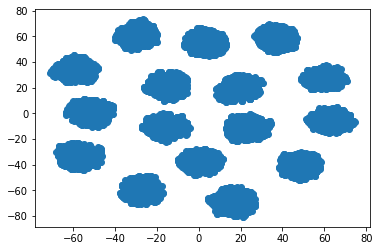

In [ ]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(noisy)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 80.14556241035461 seconds


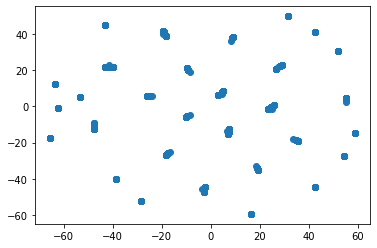

In [ ]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(encodedsymbols)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [ ]:
decoded_symbols=decoder.predict(noisy)

313/313 [==============================] - 0s 924us/step


In [ ]:
#convert the probability to hot vector
a=decoded_symbols
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


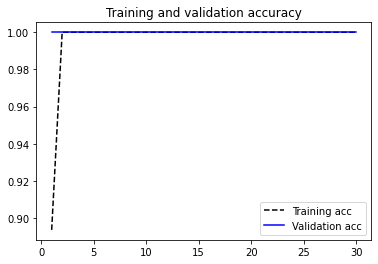

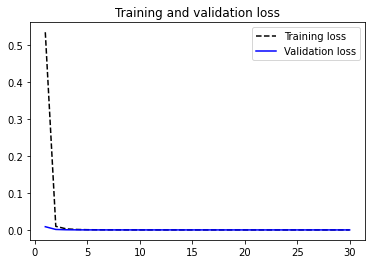

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'k--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'k--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=10000000;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB

In [ ]:
BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
  Eb_No_ratio=10**(Eb_No[i]/10);
  stddev=(2*R*Eb_No_ratio)**(-0.5);
  encodedsymbols=encoder.predict(X_test)
  noise = np.random.normal(0,stddev,[test_size,n])
  noisy=encodedsymbols+noise
  a=decoder.predict(noisy)
  idx = np.argmax(a, axis=-1)
  a = np.zeros( a.shape )
  a[ np.arange(a.shape[0]), idx] = 1
  recovered_symbols=np.argmax(a, axis=1)
  errors=np.count_nonzero(recovered_symbols-symbols)
  BER[i]=errors/len(symbols)



312500/312500 [==============================] - 375s 1ms/step


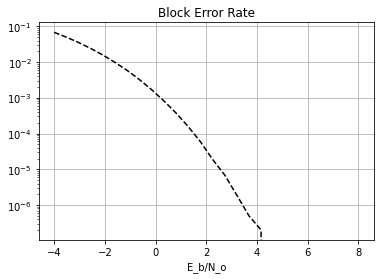

In [ ]:
import matplotlib.pyplot as plt

plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()



In [ ]:
from tensorflow.keras import layers
class AE(layers.Layer):
    def __init__(self):
            super(AE, self).__init__()
            self.fc1 = layers.Dense(16,activation='relu',input_dim=16)
            self.fc2 = layers.Dense(7,activation='linear')
            self.fc3 = layers.BatchNormalization()
            self.fc4 = layers.GaussianNoise(stddev,name='noise')
            self.fc5 = layers.Dense(16,activation='relu')
            self.fc6 = layers.Dense(16,activation='softmax')



In [ ]:
from keras.datasets import mnist, fashion_mnist
import time
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [ ]:
(X_train, y_train) , (X_test, y_test) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 8s 2us/step


In [ ]:
print(y_train[0:9])
X_train.shape


[9 0 0 3 0 2 7 2 5]


(60000, 28, 28)

In [ ]:
X = np.zeros((X_train.shape[0], 784))
type(X)

numpy.ndarray

In [ ]:
for i in range(X_train.shape[0]):
    X[i] = X_train[i].flatten()

In [ ]:
X = pd.DataFrame(X)
Y = pd.DataFrame(y_train)
X = X.sample(frac=0.1, random_state=10).reset_index(drop=True)
Y = Y.sample(frac=0.1, random_state=10).reset_index(drop=True)
df = X

In [ ]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 76.08892035484314 seconds


In [ ]:
target_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

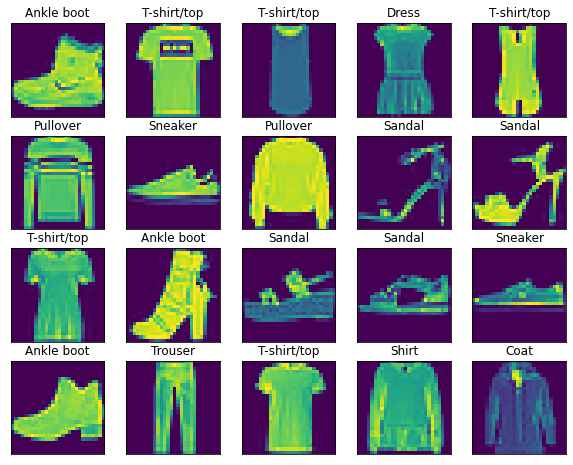

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(X_train[i] )
    plt.title( target_dict[(y_train[i]) ])
    plt.xticks([])
    plt.yticks([])

In [ ]:
#df['label']=  target_dict[(Y)]
df['label']=  Y

In [ ]:
import matplotlib.patheffects as PathEffects
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    print(palette)
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=df['label'], cmap=plt.cm.get_cmap('Paired'))
    sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        class_text=target_dict[i]
        
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(class_text), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
target_dict[2]


'Pullover'

[[0.86   0.3712 0.34  ]
 [0.86   0.6832 0.34  ]
 [0.7248 0.86   0.34  ]
 [0.4128 0.86   0.34  ]
 [0.34   0.86   0.5792]
 [0.34   0.8288 0.86  ]
 [0.34   0.5168 0.86  ]
 [0.4752 0.34   0.86  ]
 [0.7872 0.34   0.86  ]
 [0.86   0.34   0.6208]]


C:\Users\moata\AppData\Local\Temp\ipykernel_12508\1292002291.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(22.20629, -19.127361, 'T-shirt/top'),
  Text(12.443951, -72.50025, 'Trouser'),
  Text(-41.835526, 1.2663062, 'Pullover'),
  Text(-3.362826, -41.12903, 'Dress'),
  Text(-41.198936, -10.462166, 'Coat'),
  Text(33.452927, 20.339943, 'Sandal'),
  Text(-20.75988, -4.666944, 'Shirt'),
  Text(56.024727, 25.292933, 'Sneaker'),
  Text(-22.014456, 37.434864, 'Bag'),
  Text(17.149742, 57.26379, 'Ankle boot')])

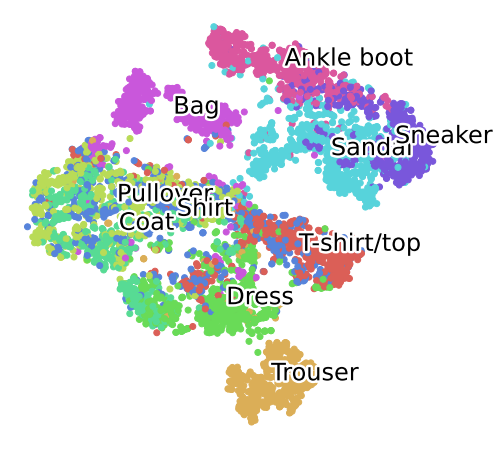

In [ ]:
plot_scatter( tsne_results,    df['label'])


In [ ]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE()
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 45.1160831451416 seconds


[[0.86   0.3712 0.34  ]
 [0.86   0.6832 0.34  ]
 [0.7248 0.86   0.34  ]
 [0.4128 0.86   0.34  ]
 [0.34   0.86   0.5792]
 [0.34   0.8288 0.86  ]
 [0.34   0.5168 0.86  ]
 [0.4752 0.34   0.86  ]
 [0.7872 0.34   0.86  ]
 [0.86   0.34   0.6208]]


C:\Users\moata\AppData\Local\Temp\ipykernel_12508\1292002291.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(6.9597745, -43.56977, 'T-shirt/top'),
  Text(65.53007, -12.801807, 'Trouser'),
  Text(-35.095665, -14.619219, 'Pullover'),
  Text(27.174772, -26.818815, 'Dress'),
  Text(-28.444517, -28.539059, 'Coat'),
  Text(1.4516324, 39.890747, 'Sandal'),
  Text(-15.888844, -16.718987, 'Shirt'),
  Text(-7.1831613, 62.632965, 'Sneaker'),
  Text(-43.89408, 21.173399, 'Bag'),
  Text(30.813278, 38.67527, 'Ankle boot')])

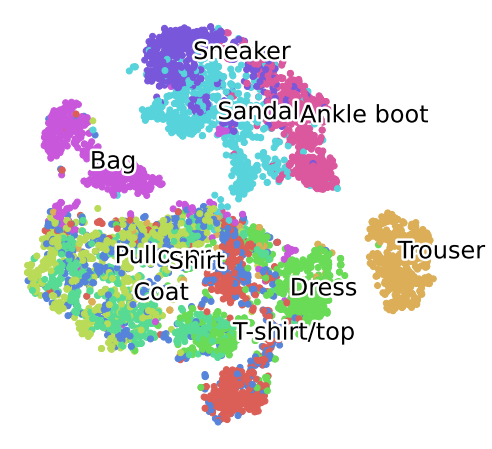

In [ ]:
plot_scatter( tsne_results,     df['label'])
